![MLU Logo](../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Computer Vision - Lecture 1</a>


## Convolutional Neural Networks with PyTorch

In this notebook, we strengthen the fundamental understanding of Convolutional Neural Network (CNN) by using built-in CNN architectures in PyTorch to train a multiclass classification model on a real-world dataset.

1. <a href="#1">A Toy Example</a>
    * <a href="#11">Convolution 2D</a> 
    * <a href="#12">Padding and Stride</a>
    * <a href="#13">Computing the Shape</a>
    * <a href="#14">Pooling</a>
    
    
2. <a href="#2">A Real-world Example - MINC</a>
    * <a href="#21">Loading the datasets</a>
    * <a href="#22">Designing the Network Architectures</a>

In [1]:
! pip install -q -r ../requirements.txt

Let's import the packages for this notebook:

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## 1. <a name="1">A Toy Example</a>
(<a href="#0">Go to top</a>)

### 1.1 <a name="11">Convolution 2D</a>
(<a href="#0">Go to top</a>)

Firstly, let's use the built-in CNN classes in PyTorch with a toy example. PyTorch has a variety of convolutional layers 
such as 


```python
nn.Conv1d()
nn.Conv2d()
nn.Conv3d()
```

and more operators in the `torch.nn` module.


### 1.2 <a name="12">Padding and Stride</a>
(<a href="#0">Go to top</a>)

In the built-in classes, we can also add padding and stride. Recall that:

"padding" adds rows/columns around the input, 

![Padding.](https://d2l.ai/_images/conv-pad.svg)


while "stride" refers to the number of "units" the kernel shifted per slide over rows/columns.

![Stride.](https://d2l.ai/_images/conv-stride.svg)



### 1.3 <a name="13">Computing the Shape</a>
(<a href="#0">Go to top</a>)


Let's experiment an example with input shape of (3, 3), with a kernel size of 2, padding size of 1 on both sides and stride size of (2, 3). The output shape of the `Conv2d()` should be:

\begin{align}
\text{ Output shape} & = \lfloor(n_h-k_h+2p_h)/s_h + 1\rfloor \times \lfloor(n_w-k_w+2p_w)/s_w + 1\rfloor \\
 & = \lfloor(3 - 2 + 2*1) / 2 + 1\rfloor \times \lfloor(3 - 2 + 2*1) / 3 + 1\rfloor \\
 & = (2, 2)
\end{align}

Let's validate in code! To check the output of the convolution layers, we define the `comp_conv2d` function as forward propagation.

In [3]:
def comp_conv2d(conv2d, X):
    # Add batch and channel dimension
    X = X.unsqueeze(0).unsqueeze(0)
    Y = conv2d(X)
    # Remove batch and channel dimension
    return Y.squeeze(0).squeeze(0)

Now we can verify the output shape of the Conv2D layer.

In [4]:
X = torch.rand(3, 3)
conv2d = nn.Conv2d(1, 1, kernel_size=2, padding=1, stride=(2,3))
print(comp_conv2d(conv2d, X).shape)

torch.Size([2, 2])


### 1.4 <a name="14">Pooling</a>
(<a href="#0">Go to top</a>)

Recall max pooling returns the maximal value in the pooling window, while average pooling summarizes the means.

![Pooling.](https://d2l.ai/_images/pooling.svg)

We can also import built-in pooling layer from PyTorch with Padding and Stride, such as `MaxPool2d()` or `AvgPool1d()`. See full list of built-in pooling architectures in the `torch.nn` module.

In [5]:
X = torch.arange(16).float().reshape((1, 1, 4, 4))
print(X)
pool2d = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
print(pool2d(X))

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])
tensor([[[[ 5.,  7.],
          [13., 15.]]]])


## 2. <a name="2">A Real-world Example - MINC</a>
(<a href="#0">Go to top</a>)

[MINC](http://opensurfaces.cs.cornell.edu/publications/minc/) is short for Materials in Context Database, provided by Cornell. __We will use a subset of this dataset with the following classes: brick, carpet, food, mirror, sky, water.__ It is well labeled and has a moderate size thus is perfect to be our example.


![MINC 2500 Examples.](https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/datasets/MINC-2500.png)


### 2.1 <a name="21">Loading the datasets</a>
(<a href="#0">Go to top</a>)

First, let's  define the paths for train, validation and test dataset. 

In [6]:
path = '../data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

It is a good practice to visualize what the dataset looks like! Let's define the `show_images` function and see some sample images in MINC.

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
        if titles:
            ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()

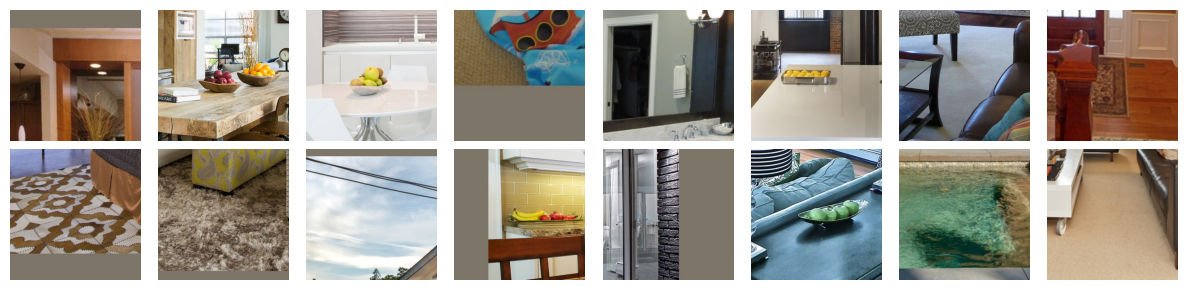

In [8]:
test_dataset = datasets.ImageFolder(test_path, transform=transforms.ToTensor())
test_sample = DataLoader(test_dataset, batch_size=16, shuffle=True)

for data, _ in test_sample:
    show_images(data, 2, 8)
    break

To load the dataset properly, we need to massage the image data a bit by some `transform` functions. First, we load the image data and resize it to the given size (224,224). Next, we convert the image to a tensor. Last, we normalize the tensor with its mean and standard deviation.

In [9]:
transformation = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Now apply the predefined transform functions and load the train, validation and test sets.

In practice, reading data can be a significant performance bottleneck, especially when our model is simple or when our computer is fast. To make our life easier when reading from the datasets, we use a `DataLoader` of PyTorch, which reads a minibatch of data with size `batch_size` each time.

In [10]:
batch_size = 16

train_dataset = datasets.ImageFolder(train_path, transform=transformation)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = datasets.ImageFolder(val_path, transform=transformation)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = datasets.ImageFolder(test_path, transform=transformation)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 2.2 <a name="22">Designing the Network Architectures</a>
(<a href="#0">Go to top</a>)

Now it's time to design the CNN neural networks! First, let's initialize a `Sequential` block. In PyTorch, `Sequential` defines a container for several layers that will be chained together. Given input data, a `Sequential` passes it through the first layer, in turn passing the output as the second layer's input and so forth.

We will build a neural network with a 2D convolutional layer `Conv2d`, followed by a 2D max pooling layer `MaxPool2d`, a fully connected (or `Linear`) layer, and a final output `Linear` layer with output classes 6.

In [11]:
out_classes = 6

net = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(20 * 110 * 110, 128),
    nn.ReLU(),
    nn.Linear(128, out_classes)
)

Our network is almost ready to be trained! One last thing before the training is to set up the hyperparameters, such as the device (GPU or CPU), the number of epochs to train, the learning rate of optimization algorithms. Besides, we specify the loss function. Since this problem is a multiclass classification task, we will use CrossEntropyLoss as our loss function.

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 10
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()

We can initialize the weights using the default initialization in PyTorch. 

To infer the neural network "how to optimize its weights", we instantiate the `optimizer`, which defines the parameters to optimize over, the optimization algorithm we wish to use (SGD), and the learning rate. SGD just requires that we set the value learning_rate.

In [19]:
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

Now it's the training time! Starting with the outer loop, we will have 10 epochs (10 full pass through our dataset).

In [20]:
for epoch in range(epochs):
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop
    net.train()
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == label).float().mean()
        train_loss += loss.item()
    
    # Validation loop
    net.eval()
    with torch.no_grad():
        for data, label in validation_loader:
            data, label = data.to(device), label.to(device)
            output = net(data)
            valid_acc += (output.argmax(1) == label).float().mean()
            val_loss += criterion(output, label).item()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print(f"Epoch {epoch}: train loss {train_loss:.3f}, train acc {train_acc:.3f}, val loss {val_loss:.3f}, val acc {valid_acc:.3f}")

Epoch 0: train loss 1.428, train acc 0.444, val loss 1.185, val acc 0.604
Epoch 1: train loss 1.080, train acc 0.582, val loss 1.030, val acc 0.578
Epoch 2: train loss 0.921, train acc 0.658, val loss 1.083, val acc 0.609
Epoch 3: train loss 0.821, train acc 0.707, val loss 1.086, val acc 0.635
Epoch 4: train loss 0.599, train acc 0.793, val loss 1.077, val acc 0.677
Epoch 5: train loss 0.536, train acc 0.815, val loss 1.139, val acc 0.630
Epoch 6: train loss 0.344, train acc 0.884, val loss 1.442, val acc 0.620
Epoch 7: train loss 0.276, train acc 0.908, val loss 1.316, val acc 0.589
Epoch 8: train loss 0.202, train acc 0.940, val loss 1.112, val acc 0.677
Epoch 9: train loss 0.094, train acc 0.973, val loss 1.171, val acc 0.667


As you may notice that the training loss and accuracy keep improving, while the validation loss and accuracy are fluctuated. This is a signal of overfitting. As a result, in the following sessions, we will show you more advanced neural network architectures (such as AlexNet and ResNet) to stabilize the training!